# Dev Notebook

## Create CN Grid




In [1]:
from osgeo import ogr
import gdal
import shapely
from shapely import wkt
import pandas as pd
import geopandas as gpd
ogr.UseExceptions()

In [2]:
gdb_path = r'T:\CCSI\TECH\TNC\SRBaseline\GIS\DOEE_open_data\Data_Downloads\soils_GSSURGO_dc\soils\gSSURGO_DC.gdb'
#gdb_path = r'C:\Users\slawler\Desktop\cn_work\gSSURGO_DC.gdb'
gdb_path

'C:\\Users\\slawler\\Desktop\\cn_work\\gSSURGO_DC.gdb'

In [3]:
# get the driver
driver = ogr.GetDriverByName("OpenFileGDB")

# opening the FileGDB
try:
    gdb = driver.Open(gdb_path, 0)

except Exception as e:
    print(e)
    SystemExit

In [4]:
# list to store layers'names
featsClassList = []

# parsing layers by index
for featsClass_idx in range(gdb.GetLayerCount()):
    featsClass = gdb.GetLayerByIndex(featsClass_idx)
    featsClassList.append(featsClass.GetName())
    
#featsClassList    

In [5]:
print('Data in GDB\n')

# printing
for featsClass in featsClassList:
    print(featsClass)

Data in GDB

chaashto
chconsistence
chdesgnsuffix
chfrags
chorizon
chpores
chstruct
chstructgrp
chtext
chtexture
chtexturegrp
chtexturemod
chunified
cocanopycover
cocropyld
codiagfeatures
coecoclass
coeplants
coerosionacc
coforprod
coforprodo
cogeomordesc
cohydriccriteria
cointerp
comonth
component
copm
copmgrp
copwindbreak
corestrictions
cosoilmoist
cosoiltemp
cosurffrags
cosurfmorphgc
cosurfmorphhpp
cosurfmorphmr
cosurfmorphss
cotaxfmmin
cotaxmoistcl
cotext
cotreestomng
cotxfmother
distinterpmd
distlegendmd
distmd
featdesc
laoverlap
legend
legendtext
mapunit
month
muaggatt
muaoverlap
mucropyld
mutext
sacatalog
sainterp
sdvalgorithm
sdvattribute
sdvfolder
sdvfolderattribute
mdstatdomdet
mdstatdommas
mdstatidxdet
mdstatidxmas
mdstatrshipdet
mdstatrshipmas
mdstattabcols
mdstattabs
MUPOLYGON
FEATLINE
FEATPOINT
MULINE
SAPOLYGON
MUPOINT
Valu1


### Read in Geospatial Data

In [6]:
# Feature in GDB to read
feature_name = 'MUPOLYGON'

# Get Feature of interest (feature_name) number of records (e.g. polygons in feature)
features =  gdb.GetLayerByName(feature_name)
feature_rows = features.GetFeatureCount()
feature_idx = range(1, feature_rows+1)

# Initialize Dataframe to store results
df = pd.DataFrame(index=feature_idx)
df['mukey'] = None
df['hydrogroup'] = None
df['geometry'] = None
df.head()

,mukey,hydrogroup,geometry
1,None,None,None
2,None,None,None
3,None,None,None
4,None,None,None
5,None,None,None


In [7]:
# Iterate through feature by rows, pick up data of interest
for row in feature_idx:
    feature = features.GetFeature(row)
    df.loc[row,'mukey']  = feature.GetField('mukey')
    df.loc[row,'geometry'] = feature.geometry().ExportToWkt()

df.head()

,mukey,hydrogroup,geometry
1,128658,None,"MULTIPOLYGON (((1622937.0308 1918600.0691,1622..."
2,128658,None,"MULTIPOLYGON (((1623559.5046 1919271.8779,1623..."
3,128658,None,"MULTIPOLYGON (((1623360.4315 1919220.543,16233..."
4,128658,None,"MULTIPOLYGON (((1623290.781 1920050.3459,16232..."
5,128658,None,"MULTIPOLYGON (((1623052.2318 1920353.4149,1623..."


In [8]:
mukeys = df['mukey'].unique()
print(f'{len(mukeys)} Unique values in {feature_name}')

129 Unique values in MUPOLYGON


### Read in Tabular Data

In [9]:
table_name = 'component'
table = gdb.GetLayerByName(table_name)
table_rows = table.GetFeatureCount()
table_idx = range(1, table_rows+1)
print(f'{table_rows} Rows in table')

for row in table_idx:
    row_data = table.GetFeature(row)
    mukey = row_data.GetField('mukey')
    hydrogroup = row_data.GetField('hydgrp')
    if mukey in mukeys:
        idxs = df[df['mukey']==mukey].index
        df.loc[idxs, 'hydrogroup'] = hydrogroup
    

424 Rows in table


In [10]:
df.head()

,mukey,hydrogroup,geometry
1,128658,None,"MULTIPOLYGON (((1622937.0308 1918600.0691,1622..."
2,128658,None,"MULTIPOLYGON (((1623559.5046 1919271.8779,1623..."
3,128658,None,"MULTIPOLYGON (((1623360.4315 1919220.543,16233..."
4,128658,None,"MULTIPOLYGON (((1623290.781 1920050.3459,16232..."
5,128658,None,"MULTIPOLYGON (((1623052.2318 1920353.4149,1623..."


In [11]:
def get_unique_pairs(groups:list):
    unique_pairs = []
    for i, group in enumerate(groups):
        j=i
        while j < len(groups):
            if j!=i:
                unique_pairs.append(groups[i]+'/'+ groups[j])
            else:
                unique_pairs.append(groups[i])
            j+=1
    return unique_pairs

In [12]:
groups = ['A', 'B', 'C', 'D']
hydrogroups = get_unique_pairs(groups)
#hydrogroups.append('None')

In [13]:
hydrogroups_table = dict()
for i, group in enumerate(hydrogroups):
    hydrogroups_table[group] = i+222

hydrogroups_table

{'A': 222,
 'A/B': 223,
 'A/C': 224,
 'A/D': 225,
 'B': 226,
 'B/C': 227,
 'B/D': 228,
 'C': 229,
 'C/D': 230,
 'D': 231}

In [14]:
df['GroupCode'] = -9999
for idx in df.index:
    try:
        df.loc[idx, 'GroupCode'] = int(hydrogroups_table[df.loc[idx, 'hydrogroup']])
    except:
        continue

In [15]:
df.tail()

,mukey,hydrogroup,geometry,GroupCode
2640,128654,B,"MULTIPOLYGON (((1624251.7713 1928287.4348,1624...",226
2641,128654,B,"MULTIPOLYGON (((1615154.8732 1928383.0799,1615...",226
2642,128654,B,"MULTIPOLYGON (((1625021.3943 1928400.2336,1625...",226
2643,128654,B,"MULTIPOLYGON (((1625199.3961 1929032.3149,1625...",226
2644,128654,B,"MULTIPOLYGON (((1625528.3685 1929578.8738,1625...",226


In [16]:
georef = feature.GetGeometryRef()
spatial_ref = georef.GetSpatialReference()
prj = spatial_ref.ExportToWkt()
prj

'PROJCS["USA_Contiguous_Albers_Equal_Area_Conic_USGS_version",GEOGCS["GCS_North_American_1983",DATUM["North_American_Datum_1983",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["longitude_of_center",-96.0],PARAMETER["Standard_Parallel_1",29.5],PARAMETER["Standard_Parallel_2",45.5],PARAMETER["latitude_of_center",23.0],UNIT["Meter",1.0],AUTHORITY["Esri","102039"]]'

In [17]:
geom =  pd.Series(df['geometry']).apply(shapely.wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry=geom)
gdf.crs = prj
gdf.head()

,mukey,hydrogroup,geometry,GroupCode
1,128658,None,"(POLYGON ((1622937.0308 1918600.0691, 1622931....",-9999
2,128658,None,"(POLYGON ((1623559.5046 1919271.8779, 1623567....",-9999
3,128658,None,"(POLYGON ((1623360.4315 1919220.543, 1623352.7...",-9999
4,128658,None,"(POLYGON ((1623290.781 1920050.3459, 1623280.0...",-9999
5,128658,None,"(POLYGON ((1623052.2318 1920353.4149, 1623062....",-9999


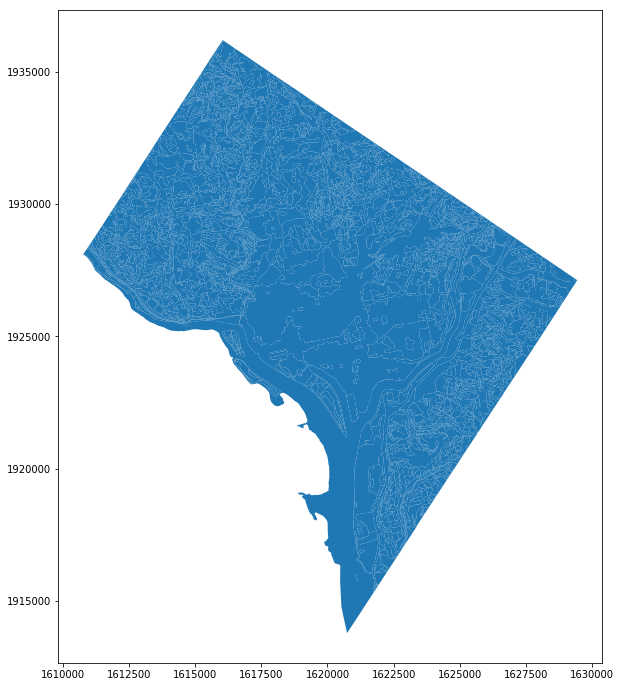

In [18]:
%matplotlib inline
gdf.plot(figsize=(12,12))

TODO: Make srcDS

In [19]:
#gdal.Rasterize(gdf.geometry)

In [20]:
bounds = gdf['geometry'].bounds

In [21]:
for col in bounds:
    if 'min' in col:
        print(col, min(bounds[col]))
    else:
        print(col, max(bounds[col]))

minx 1610772.5545
miny 1913793.0716
maxx 1629435.0153
maxy 1936192.9638


In [23]:
#rf = r'T:\CCSI\TECH\TNC\SRBaseline\GIS\DOEE_open_data\Data_Downloads\nlcd_2011_landcover_2011_edition_2014_10_10\nlcd_2011_landcover_2011_edition_2014_10_10

In [24]:
minx= 1610772.5545
miny=1913793.0716
maxx=1629435.0153
maxy=1936192.9638

In [31]:
def array2raster(newRasterfn,spatial_ref,rasterOrigin,pixelWidth,pixelHeight,array):
    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = spatial_ref
    #outRasterSRS.ImportFromEPSG(4326)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

In [32]:
import gdal, ogr, os, osr
import numpy as np

In [35]:
rasterOrigin = (maxx,miny)
ysize = 1000
xsize = 1000
raster_name = 'test4.tif'
array = np.array([[ 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                  [ 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                  [ 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1],
                  [ 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1],
                  [ 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1],
                  [ 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1],
                  [ 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
                  [ 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                  [ 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                  [ 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
array2raster(raster_name,spatial_ref,rasterOrigin,xsize,ysize,array.T)
